In [2]:
import os
import librosa
import warnings
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.io import wavfile
warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")

# Load Audio File

In [31]:
filepath = '11-2-22/voice_command1_snr-10.mp3'# '11-2-22/test_male3.mp3'
audio, sr = librosa.load(filepath)
print(f"Filepath: {filepath}")

Filepath: 11-2-22/voice_command1_snr-10.mp3


In [27]:
# wavfile.write('11-2-22/voice_command1-volume.mp3', sr, audio.astype('f4') * 6)

Range of the amplitude in time domain signal is [-1, 1]

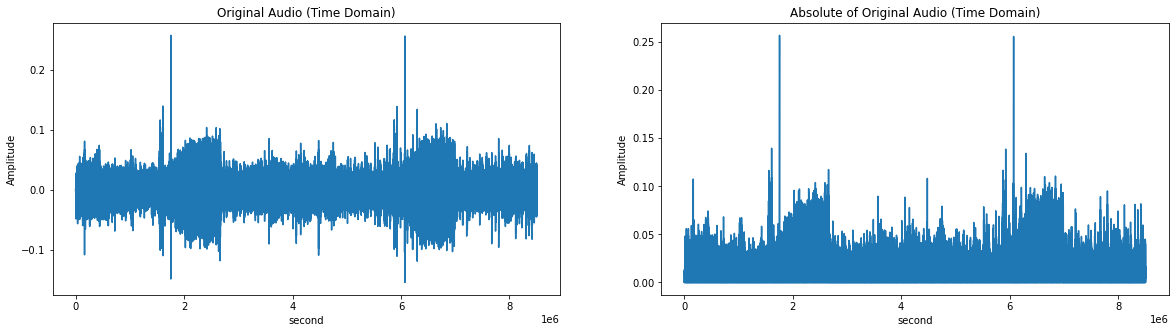

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(audio)
ax[0].set_title('Original Audio (Time Domain)')
ax[0].set_xlabel('second')
ax[0].set_ylabel('Amplitude')

ax[1].plot(np.abs(audio))
ax[1].set_title('Absolute of Original Audio (Time Domain)') # <== make the range to [0, 1]
ax[1].set_xlabel('second')
ax[1].set_ylabel('Amplitude')
plt.show()

# Segment the audio and Find peak level signal

In [33]:
norm_audio = np.abs(audio) # <== in order to make the peak level between 0 and 1
s = 0.1
step  = int(s * sr) # <== change from ms to step
audio_length = len(norm_audio)
start = 0

li = []
audio_li = []
pbar = tqdm(range(step, audio_length + step, step), desc="Cutting Process")
for stop in pbar:
  chunk = norm_audio[start:stop]
  cut_audio = audio[start:stop]
  li.append(chunk)
  audio_li.append(cut_audio)
  start = stop

li = np.array(li, dtype=object)
audio_li = np.array(audio_li, dtype=object)

l = np.array(list(map(lambda x: max(x), li))) # <= peak level signal of each chunk

Cutting Process: 100%|██████████| 3858/3858 [00:00<00:00, 964339.98it/s]


# EM Algorithm

## Strategy Expectation, and Maxmization

In [5]:
class ExpectInterface:
  def expectation(self, mu, sigma, data):
    pass

class MaximizeInterface:
  def maximization(self, expect, data):
    pass

class Expect(ExpectInterface):
  def expectation(self, mu, sigma, data):
    zb = (data - mu[0]) / sigma[0]
    zs = (data - mu[1]) / sigma[1]
    return (zs**2 < zb**2).astype(int)   

class Maximize(MaximizeInterface):
  def maximization(self, expect, data):
    data_b = data[expect == 0]
    data_s = data[expect == 1]
    new_mu = [data_b.mean(), data_s.mean()]
    new_sigma = [data_b.std(), data_s.std()]
    return np.array(new_mu), np.array(new_sigma)

## EM Model

In [6]:
class EMModel:
  def __init__(self, expect=None, maximize=None):
    self.expect = expect
    self.maximize = maximize
    self.mu = None
    self.sigma = None

  def init_param(self):
    self.mu = np.random.rand(2)
    self.sigma = np.random.rand(2)

  def expectation(self, mu, sigma, data):
    return self.expect.expectation(mu, sigma, data)
  
  def maximization(self, expect, data):
    return self.maximize.maximization(expect, data)
    
  def update(self, t, delta, new_mu, new_sigma):
    new_var = new_sigma ** 2
    if np.any(new_var < t**2):
      new_var += new_var.sum() / (2 * delta)
  
    if np.allclose(new_mu, self.mu) and np.allclose((new_var ** 0.5), self.sigma):
      return False

    self.mu = new_mu
    self.sigma = new_var ** 0.5
    return True
  
  def run(self, data, delta=16, max_epoch=100):
    t = 0.5 * max(data)
    
    ## Initialize Mean and Sigma, until it predict more than one class.
    self.init_param()
    sample_expect = self.expectation(self.mu, self.sigma, data)
    while (sample_expect==0).sum() == 0 or (sample_expect==1).sum() == 0:
      self.init_param()
      sample_expect = self.expectation(self.mu, self.sigma, data)
    ####################################################################

    epoch = 0
    while True:
      if epoch > max_epoch:
        print("Not Converge")
        break
      
      expect = self.expectation(self.mu, self.sigma, data)
      new_mu, new_sigma = self.maximization(expect, data)
      updated = self.update(t, delta, new_mu, new_sigma)
      if not updated:
        break
      epoch += 1
    
    mask = np.argsort(self.mu)
    self.mu = self.mu[mask]
    self.sigma = self.sigma[mask]
  
  def set_expect(self, expect):
    self.expect = expect
  
  def set_maximize(self, maximize):
    self.maximize = maximize

In [13]:
em = EMModel(Expect(), Maximize())

In [14]:
em.run(l)
print("Final Mean:", em.mu)
print("Final Sigma:", em.sigma)

Final Mean: [0.03051599 0.10981377]
Final Sigma: [0.01060549 0.04809542]


# Gain Strategy

In [15]:
class AGC:
  def __init__(self, em, theta0=0.8, theta1=0.1):
    self.em = em
    self.theta0 = theta0
    self.theta1 = theta1
    self.initGain()
  
  def initGain(self):
    mu = self.em.mu
    sigma = self.em.sigma
    if mu[1] - mu[0] > sigma[1] + sigma[0]:
      self.gain  = self.theta0 / (mu[1] + sigma[1])
    else:
      self.gain = self.theta1 / min(mu[1] + sigma[1], mu[0] + sigma[0])
    self.gain = max(1, self.gain) # <= not attenuate
  
  def createOORmask(self, up_audio_li): # <= create out of range mask, in order to replace the chunks that is out of range with original chunks.
    max_func = np.vectorize(lambda x: max(x))
    min_func = np.vectorize(lambda x: min(x))
    max_li = max_func(up_audio_li)
    min_li = min_func(up_audio_li)

    max_mask = max_li > 1
    min_mask = min_li < -1
    return np.logical_or(max_mask, min_mask)

  def scaleUp(self, audio_li):
    mu = self.em.mu
    sigma = self.em.sigma
    l = np.array(list(map(lambda x: x.max(), audio_li)))
    expect = self.em.expectation(mu, sigma, l)

    up_audio_li = audio_li.copy() 
    up_audio_li[expect == 1] *= self.gain # scale up the specific chunks 
    # No Clipping: if amplitude is not in range [-1, 1], then we don't scale up that chunk
    mask = self.createOORmask(up_audio_li)
    up_audio_li[mask] = audio_li[mask]
    return up_audio_li

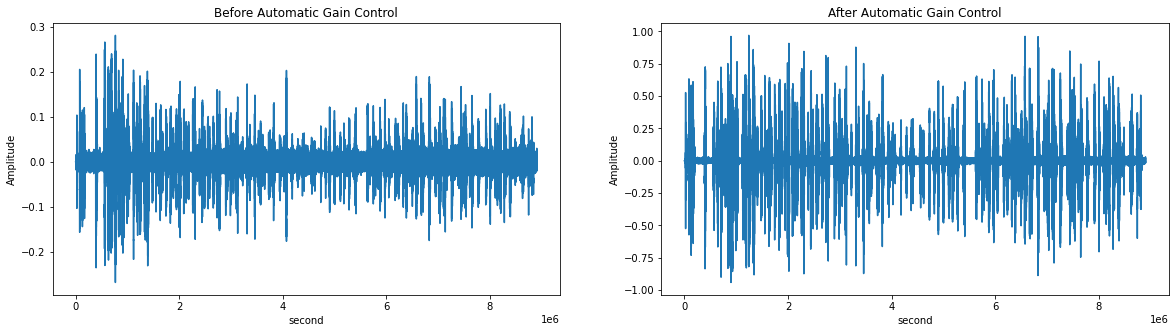

In [16]:
g = AGC(em)
new_audio_li = g.scaleUp(audio_li)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(np.concatenate(audio_li))
ax[0].set_title('Before Automatic Gain Control')
ax[0].set_xlabel('second')
ax[0].set_ylabel('Amplitude')

ax[1].plot(np.concatenate(new_audio_li))
ax[1].set_title('After Automatic Gain Control') # <== make the range to [0, 1]
ax[1].set_xlabel('second')
ax[1].set_ylabel('Amplitude')
plt.show()

In [18]:
wavfile.write('test.mp3', sr, np.concatenate(new_audio_li).astype('f4'))

# Automatic Gain Control

In [8]:
class Expect:
  def expectation(self, mu, sigma, data):
    zb = (data - mu[0]) / sigma[0]
    zs = (data - mu[1]) / sigma[1]
    return (zs**2 < zb**2).astype(int) 

class Maximize:
  def maximization(self, mu, sigma, k_mu, k_sigma, expect, data):
    new_mu = mu.copy()
    new_mu[expect] = k_mu * data + (1-k_mu) * mu[expect]
    new_var = sigma.copy() ** 2
    new_var[expect] = k_sigma * ((data-new_mu[expect])**2) + (1-k_sigma) * new_var[expect] # <= change
    new_sigma = new_var ** 0.5
    return new_mu, new_sigma

In [9]:
class AGCModel:
  def __init__(self, expect=None, maximize=None, k_mu=0.5, k_sigma=0.33, theta0=0.8, theta1=0.1):
    self.expect = expect
    self.maximize = maximize
    self.k_mu = k_mu
    self.k_sigma = k_sigma
    self.theta0 = theta0
    self.theta1 = theta1
    self.t = 0
    self.mu = None
    self.sigma = None

  def init_param(self, data):
    self.mu = np.ones(2) * 0.035375495 # data.mean()
    self.sigma = np.ones(2) * 0.010877407 # data.std()

  def expectation(self, mu, sigma, data):
    return self.expect.expectation(mu, sigma, data)
  
  def maximization(self, mu, sigma, k_mu, k_sigma, expect, data):
    return self.maximize.maximization(mu, sigma, k_mu, k_sigma, expect, data)
    
  def update(self, t, delta, new_mu, new_sigma):
    new_var = new_sigma ** 2
    if np.any(new_var < t**2):
      new_var += new_var.sum() / (2 * delta)

    self.mu = new_mu
    self.sigma = new_var ** 0.5
    # Sort mu, so that class s is at index 1
    mask = np.argsort(self.mu)
    self.mu = self.mu[mask]
    self.sigma = self.sigma[mask]
  
  def computeGain(self, expect):
    if expect == 0: # <= predict as background
      return 1.0
    mu = self.mu
    sigma = self.sigma
    gain = 1.0
    if mu[1] - mu[0] > sigma[1] + sigma[0]:
      gain  = self.theta0 / (mu[1] + sigma[1])
    else:
      gain = self.theta1 / min(mu[1] + sigma[1], mu[0] + sigma[0])
    return max(1.0, gain) # <= not attenuate

  def run(self, data, delta=16):
    if self.mu is None or self.sigma is None:
      self.init_param(data)
    t = (0.5 * max(data))**2
    if t > self.t:
      self.t = t

    expects = []
    gain = []
    for l in data:
      expect = self.expectation(self.mu, self.sigma, l)
      gain.append(self.computeGain(expect))
      expects.append(expect)
      new_mu, new_sigma = self.maximization(self.mu, self.sigma, self.k_mu, self.k_sigma, expect, l)
      self.update(self.t, delta, new_mu, new_sigma)
    return np.array(gain), np.array(expects)

  def scaleUp(self, gain, audio_li):
    max_func = lambda x: abs(max(x))
    min_func = lambda x: abs(min(x))

    max_amp, min_amp = np.array(list(map(max_func, audio_li))).reshape(-1, 1), np.array(list(map(min_func, audio_li))).reshape(-1, 1)
    peak_amp = np.concatenate((max_amp, min_amp), axis=1).max(1)
    peak_amp_gain = peak_amp * gain

    mask = peak_amp_gain > 1
    gain_no_clip = gain.copy()
    gain_no_clip[mask] = 1 / peak_amp[mask]
    gain_no_clip[gain_no_clip < 1] = 1
    up_scale_audio_li = audio_li.copy()
    if len(up_scale_audio_li.shape) == 2:
      gain_no_clip = np.expand_dims(gain_no_clip, axis=1)
    up_scale_audio_li *= gain_no_clip
    return up_scale_audio_li

  def set_expect(self, expect):
    self.expect = expect
  
  def set_maximize(self, maximize):
    self.maximize = maximize

In [10]:
model = AGCModel(Expect(), Maximize())
gain, expects = model.run(l)
up_scale_audio_li = model.scaleUp(gain, audio_li)

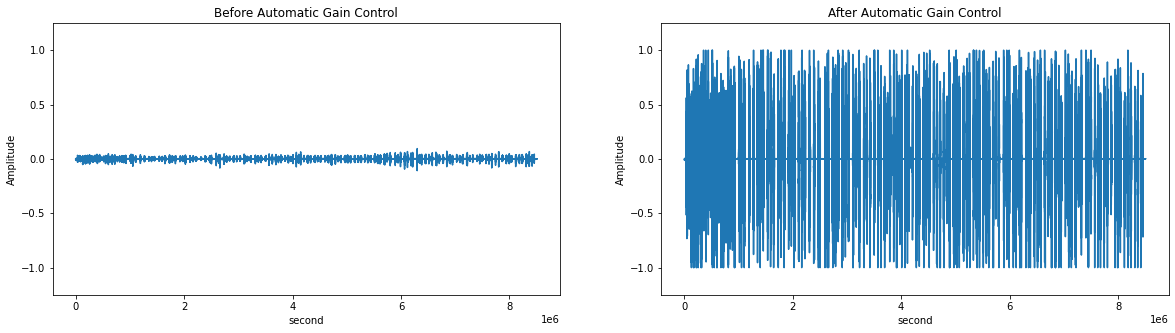

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(np.concatenate(audio_li))
ax[0].set_title('Before Automatic Gain Control')
ax[0].set_xlabel('second')
ax[0].set_ylabel('Amplitude')
ax[0].set_ylim((-1.25, 1.25))

ax[1].plot(np.concatenate(up_scale_audio_li))
ax[1].set_title('After Automatic Gain Control') # <== make the range to [0, 1]
ax[1].set_xlabel('second')
ax[1].set_ylabel('Amplitude')
ax[1].set_ylim((-1.25, 1.25))
plt.show()

In [95]:
wavfile.write('test.mp3', sr, np.concatenate(up_scale_audio_li).astype('f4'))

# Cut Audio Based on expectation

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 1 0 0 1 0 0 0 0 0 0]


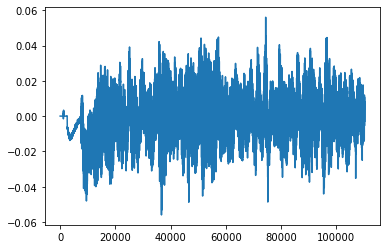

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0]


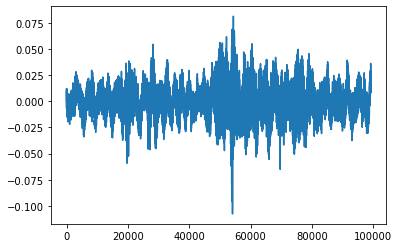

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0]


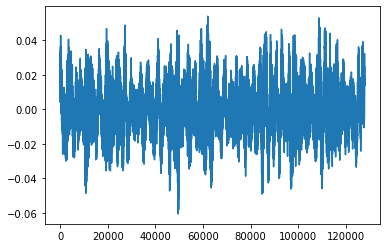

[0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]


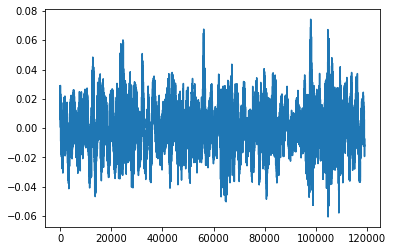

[0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0]


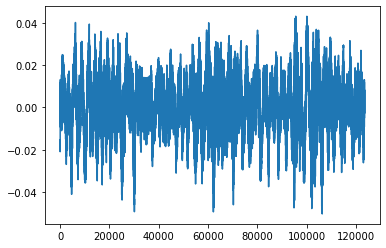

[0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0]


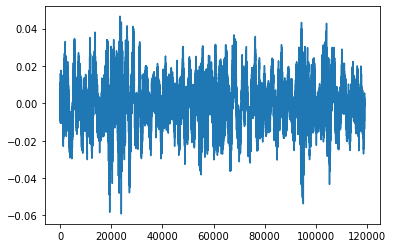

[0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0
 0 0 0 0 0 0 0 0]


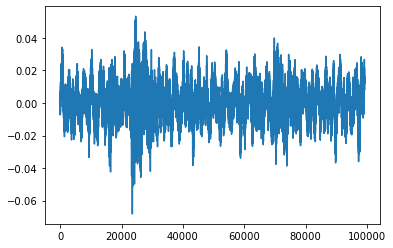

[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 1 1 0 0 0 0 0]


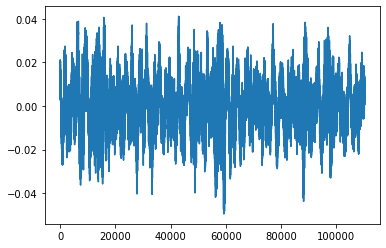

[0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0]


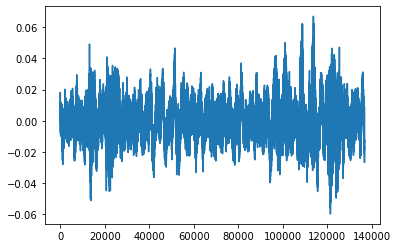

[0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


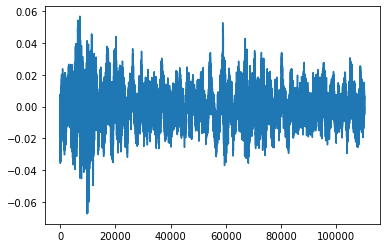

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


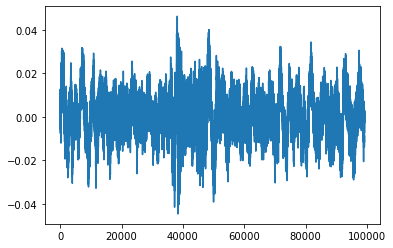

[0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0]


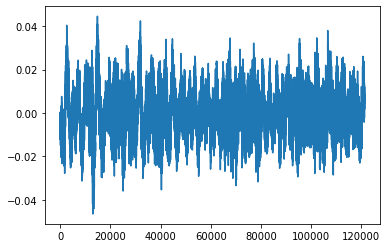

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0]


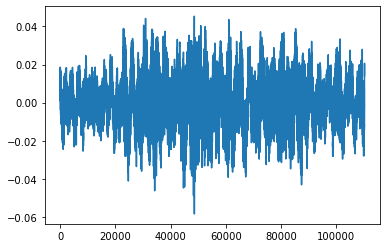

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


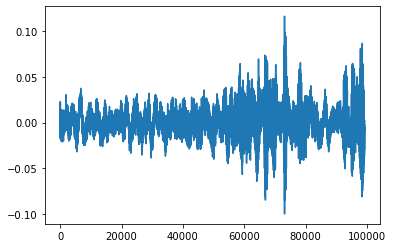

[0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


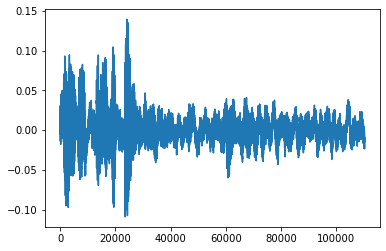

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 0 0 0 0 0]


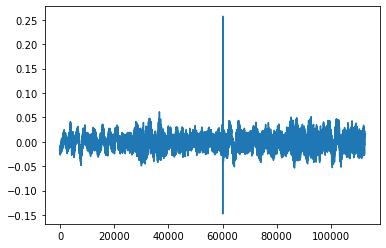

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


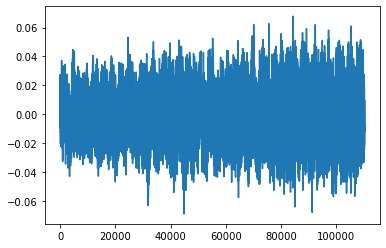

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0]


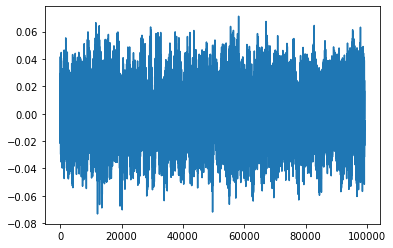

[0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0]


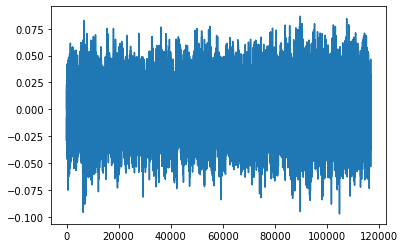

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 0 0 0 0 0]


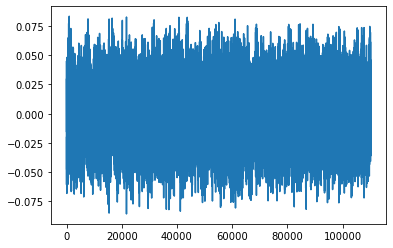

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


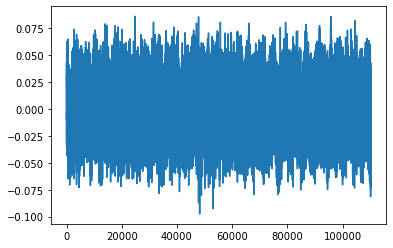

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


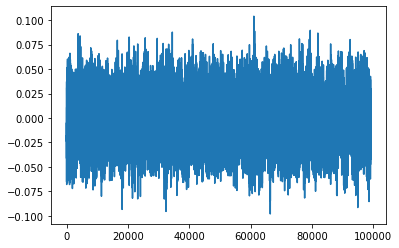

[0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


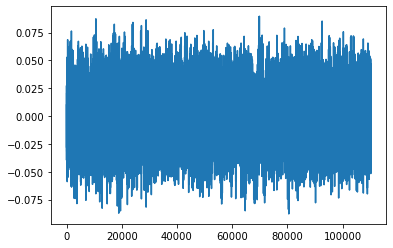

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]


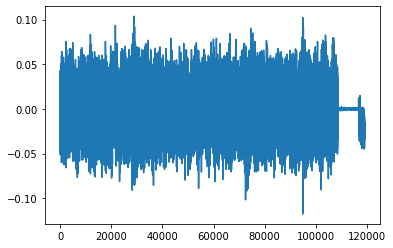

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0]


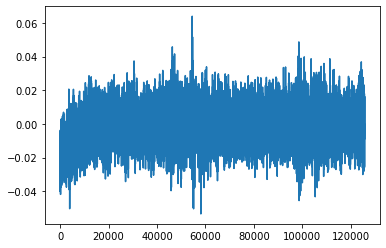

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


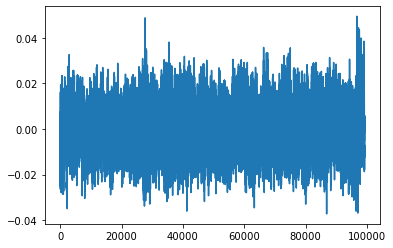

[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


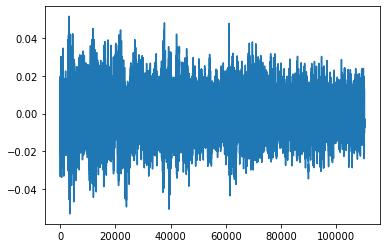

[0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0]


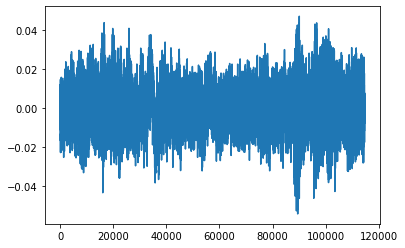

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0]


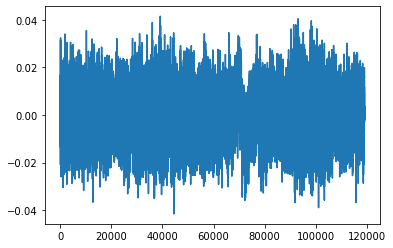

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0]


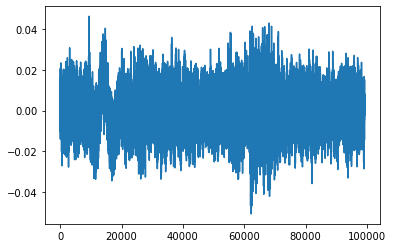

[0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0]


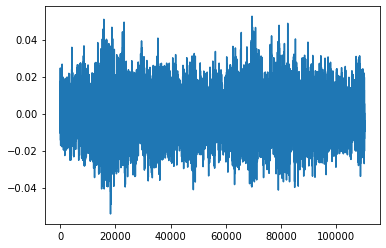

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


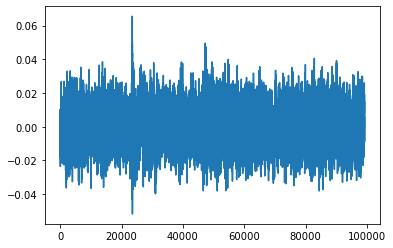

[0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


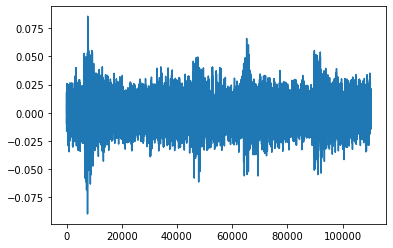

[0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0]


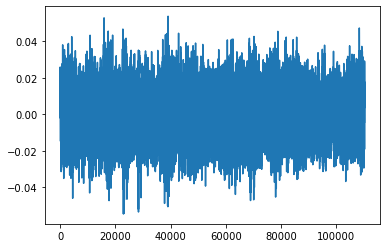

[0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0]


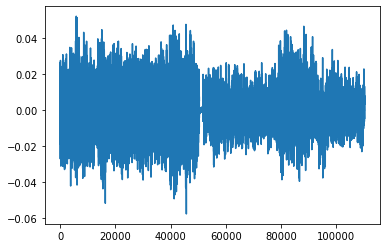

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0]


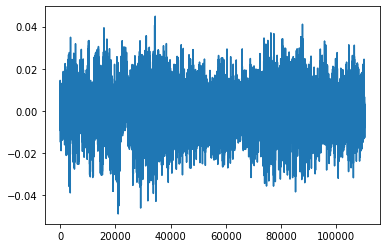

[0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0]


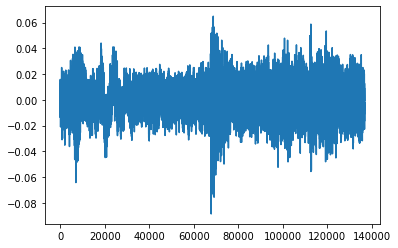

[0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


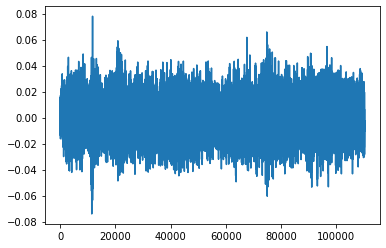

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 1 1 1 0 0 0 0 0 0 0 0 0]


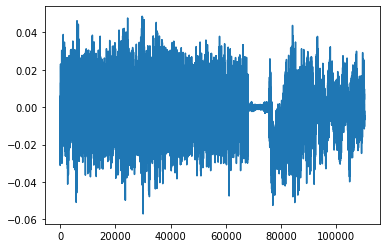

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


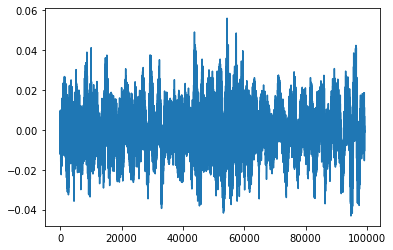

[0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


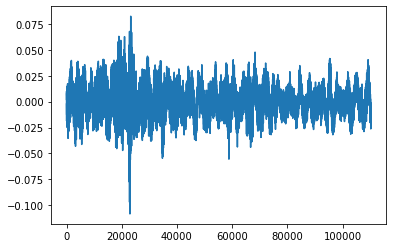

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0 0 0]


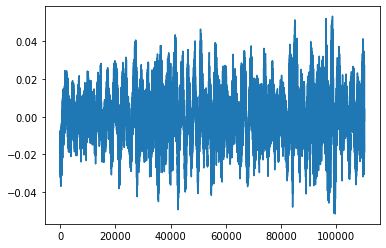

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


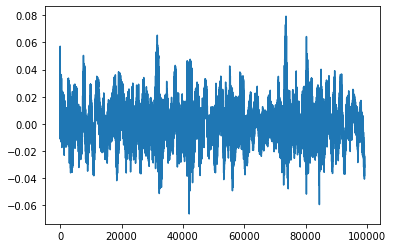

[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0]


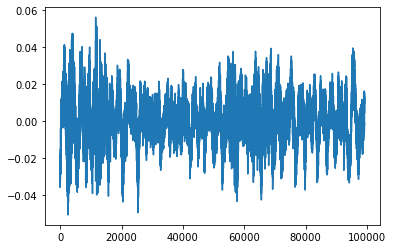

[0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 0 0 0 0 0]


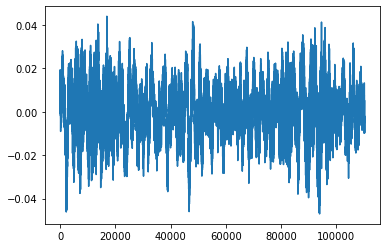

[0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0]


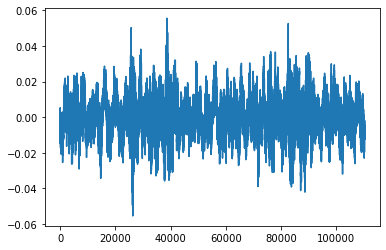

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


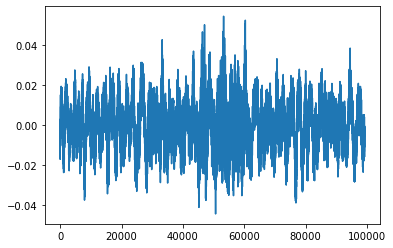

[0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


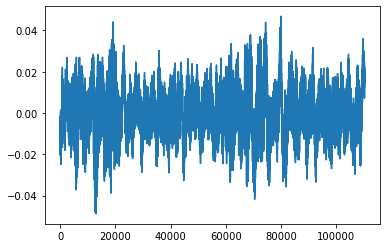

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0]


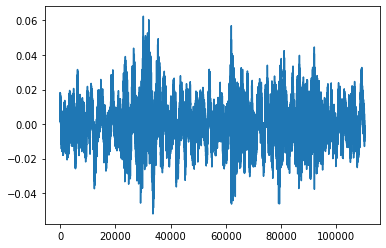

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0]


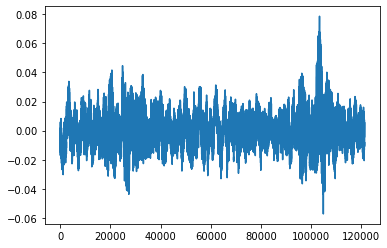

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0]


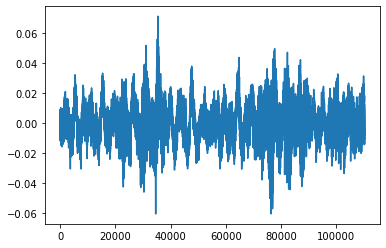

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]


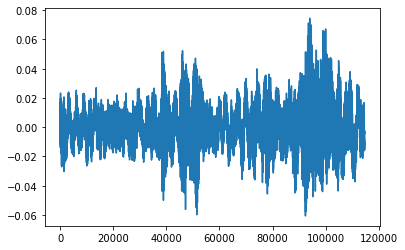

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


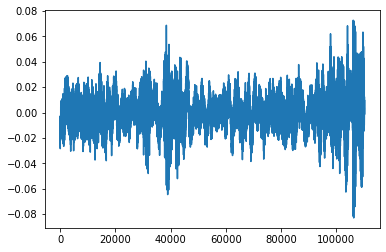

[0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0]


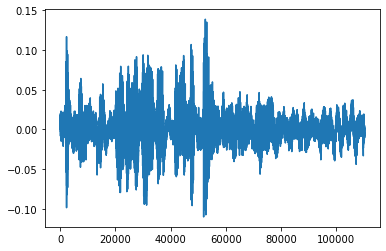

[0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 0 0 0 0 0]


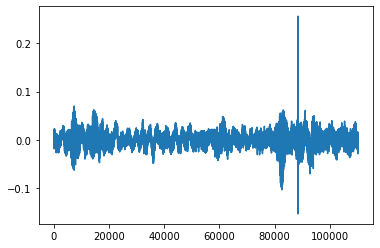

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 0 0 0 0 0]


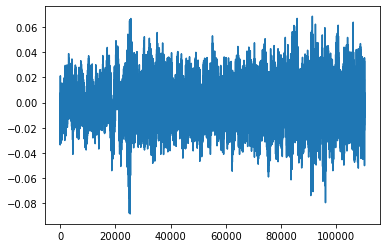

[0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0]


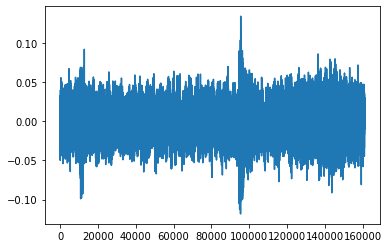

[0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0]


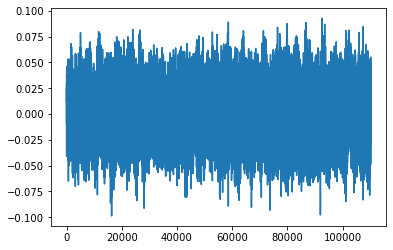

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0]


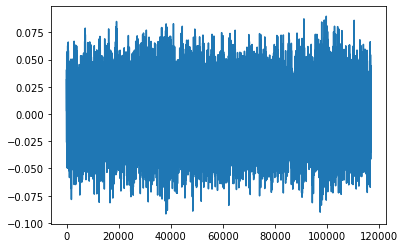

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


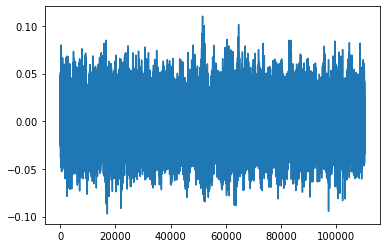

[0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0]


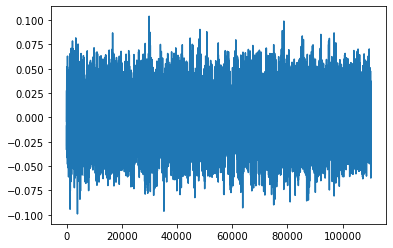

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 0 0 0 0 0]


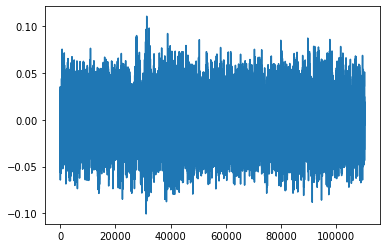

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


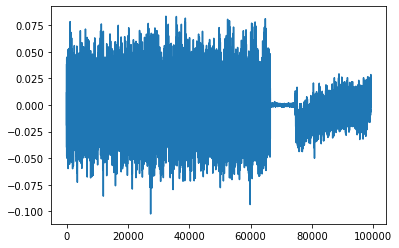

[0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


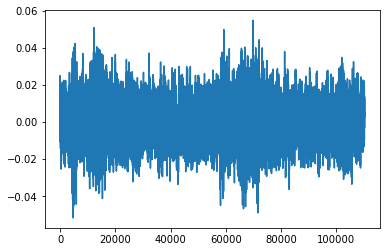

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0]


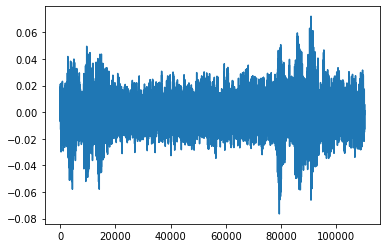

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0]


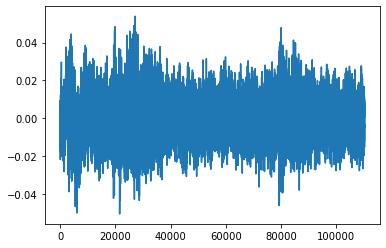

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0]


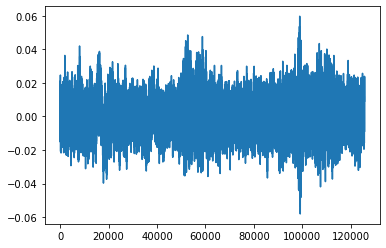

[0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0]


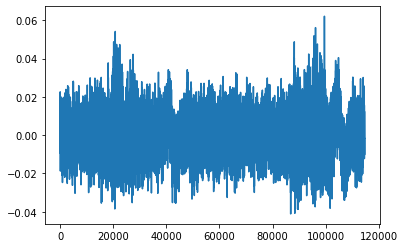

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0]


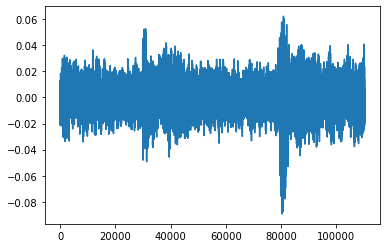

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0]


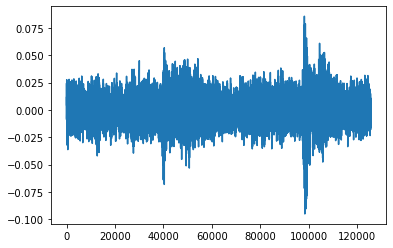

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


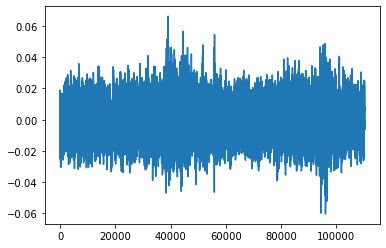

[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0]


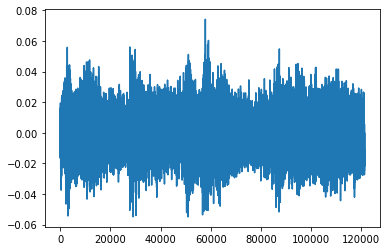

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0]


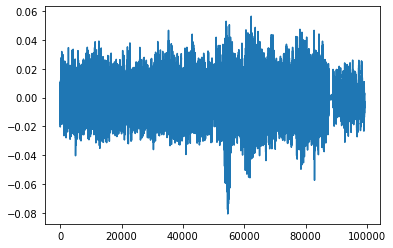

[0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0]


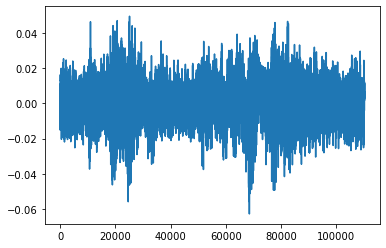

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0]


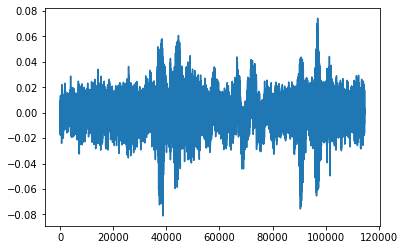

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


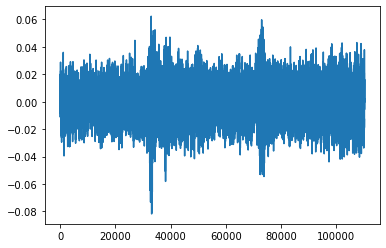

[0 0 0 0 0]


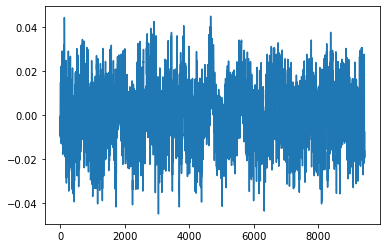

In [34]:
idx = 0
len_clip = 45
n_cat = 5
start_idx = 0
stop_idx = 0
len_audio = audio_li.shape[0]
while True:
  if start_idx >= len_audio:
    break
  stop_idx = start_idx + len_clip
  while True:
    if expects[stop_idx:stop_idx+n_cat].sum() == 0:
      stop_idx += n_cat
      break
    if expects[stop_idx-n_cat:stop_idx].sum() == 0:
      break
    stop_idx += 1

  print(expects[start_idx:stop_idx])
  wavfile.write(f'shortAudio/original/voice_command1_snr-10/voice_command1_snr-10_{idx}.mp3', sr, np.concatenate(audio_li[start_idx:stop_idx]).astype('f4'))
  plt.plot(np.concatenate(audio_li[start_idx:stop_idx]))
  plt.show()
  start_idx = stop_idx
  idx+=1